In [1]:
import simpy
import random
import statistics
import matplotlib.pyplot as plt
import numpy as np

In [2]:
completion_queue = []
packet_dict = {} # packet id is key, packet info is values (ID:[Values])

class DataCenter(object):
    def __init__(self, env, num_nodes, num_switches, num_storage):
        self.env = env
        self.node = simpy.Resource(env, num_nodes)      #resource that allocates the number of nodes in the datacenter
        self.switch = simpy.Resource(env, num_switches) #resource that allocates the number of network switches in the datacenter
        self.storage = simpy.Resource(env, num_storage) #resource that alloactes the nuber of storage in the datacenter
        
    #computes the time(in steps) that it takes to do compute work on the packet (between 10-30 steps)
    def compute_packet(self, packet):
        time = random.randint(10,30)
        yield self.env.timeout(time)
        return time
    
    #computes the time(in steps) that it takes to allocate the packet to a compute node (1 step)
    def allocate_packet(self, packet):
        time = 1
        yield self.env.timeout(1)
        return time
    
    #computes the time(in steps) that it takes to access storage for a specific packet (between 30-50 steps)
    def access_storage(self, packet):
        time = random.randint(30,50)
        yield self.env.timeout(time)
        return time
    
def work_queue(env, packet, DataCenter):
    
    #packet arrives at datacenter
    arrival_time = env.now
    
    #print("Packet ", packet, " arrived at: ", env.now)
    
    #initializing our packet_dict to be empty
    packet_dict[packet] = [0]*5
    
    #request a switch(since its a resource) and release it when we are done using it
    packet_dict[packet].append("Waiting for Switch")
    with DataCenter.switch.request() as request:
        yield request
        resSwitch = yield env.process(DataCenter.allocate_packet(packet))
        
    switch_time = resSwitch
    
    #print("Packet ", packet, " passed switch at: ", env.now, "took ", switch_time, " steps")
    
    #packet_dict[packet].append(switch_time)
    packet_dict[packet][0] = switch_time
    packet_dict[packet][5] = ("Waiting for Compute")
    switch_wait_time = env.now - switch_time - arrival_time
    
    if switch_wait_time > 0:
        print("Packet ", packet," had to wait for switch. Took ", switch_wait_time, " steps")
    
        
    #request a node(since its a resource) and release it when we are done using it
    with DataCenter.node.request() as request:
        yield request
        resComp = yield env.process(DataCenter.compute_packet(packet))
        
    #compute_time = env.now - switch_time - arrival_time
    compute_time = resComp
    
    #print("Packet ", packet, " passed compute at: ", env.now, " took ", compute_time, " steps")
    
    #packet_dict[packet].append(compute_time)
    packet_dict[packet][1] = compute_time
    compute_wait_time = env.now - compute_time - switch_time - arrival_time - switch_wait_time
    
    if compute_wait_time > 0:
        print("Packet ", packet," had to wait for compute. Took ", compute_wait_time, " steps")
        
    #randomly request storage(since its a resource) and release it when we are done using it
    if random.choice([True, False]):
        packet_dict[packet][5] = "Waiting on Storage"
        with DataCenter.storage.request() as request:
            yield request
            resStore = yield env.process(DataCenter.access_storage(packet))
        
        storage_time = resStore
        
        #print("Packet ", packet, " passed storage at: ", env.now, " took ", storage_time, " steps")
        
        #packet_dict[packet].append(storage_time)
        packet_dict[packet][2] = storage_time
        packet_dict[packet][5] = "Working on Storage"
        storage_wait_time = env.now - storage_time - compute_time - switch_time - arrival_time - compute_wait_time
        
        if storage_wait_time > 0:
            print("Packet ", packet," had to wait for storage. Took ", storage_wait_time, " steps")
            
    else:
        storage_time = 0
        #packet_dict[packet].append(storage_time)
        packet_dict[packet][2] = storage_time
            
    #packet leaves datacenter
    
    #print("packet arrival time: ", arrival_time)
    #print("~~ Packet ", packet, " finished!!")
    
    wait_time = env.now - storage_time - compute_time - switch_time - arrival_time
    #packet_dict[packet].append(env.now - arrival_time)
    packet_dict[packet][3] = env.now - arrival_time
    #packet_dict[packet].append(wait_time)
    packet_dict[packet][4] = wait_time
    #packet_dict[packet].append("DONE!")
    packet_dict[packet][5] = "DONE!"
    completion_queue.append(env.now - arrival_time) #this computes the total time it took for the packet to pass through our datacenter
    #print("packet finish time: ", env.now)

    
#This function sets up the Datacenter environment and generates the packets
def run_datacenter(env, num_nodes, num_switches, num_storage):
    datacenter = DataCenter(env, num_nodes, num_switches, num_storage)
    
    packet = 0
    
    #This loop generates packets and sends them through the datacenter
    while True:
        packet += 1
        env.process(work_queue(env, packet, datacenter))
        
        yield env.timeout(1)

        
#The function gets the amount of each resource(nodes, switches, and storage) from the user
def get_user_input():
    num_nodes = input("Input # of nodes in datacenter: ")
    num_switches = input("Input # of switches in datacenter: ")
    num_storage = input("Input # of storage in datacenter: ")
    params = [num_nodes, num_switches, num_storage]
    if all(str(i).isdigit() for i in params):
        params = [int(x) for x in params]
        
    else:
        print("Unacceptable values entered for input","\n Using default values: 20 nodes, 2 switches, 5 storage")
        params = [20,2,5]
        
    return params

def main():
    
    #setup
    random.seed(69)
    num_nodes, num_switches, num_storage = get_user_input()
    
    #run simulation
    env = simpy.Environment()
    env.process(run_datacenter(env,num_nodes, num_switches, num_storage))
    env.run(until=1000)
    
    #print each individual computation
    #for a in range(len(completion_queue)):
    #    print("completed packet: ", a+1, " in ", completion_queue[a], " steps")
    
    print("completed ", len(completion_queue), " packets in ", env.now, " steps.")
    
if __name__ == '__main__':
    main()

Input # of nodes in datacenter: 100
Input # of switches in datacenter: 100
Input # of storage in datacenter: 100
completed  959  packets in  1000  steps.


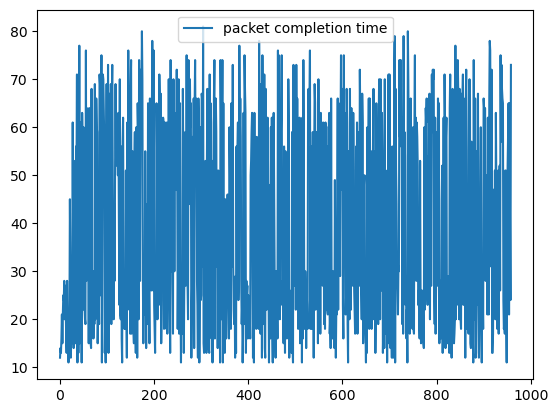

In [3]:
plt.plot(completion_queue, label='packet completion time')
plt.legend()
plt.show()

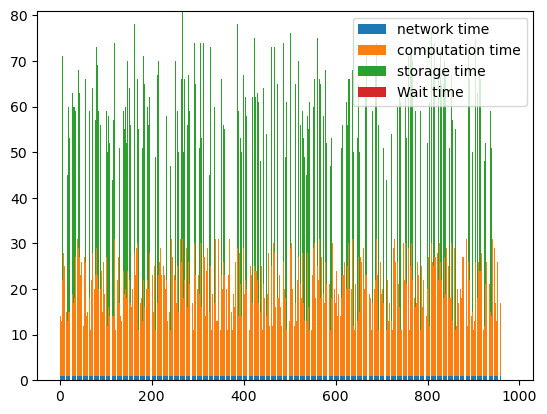

In [4]:
#This cell is used to print a graph of all of the completed packets
completed_dict = {}
for i in range(len(packet_dict)):
    if packet_dict[i+1][5] == 'DONE!':
        completed_dict[i+1] = packet_dict[i+1]
        
packets = np.array(list(completed_dict.keys()))

#getting data formated
net_time = []
comp_time = []
store_time = []
tot_wait_time = []
for i in range(len(packets)):
    net_time.append(completed_dict[packets[i]][0])
    comp_time.append(completed_dict[packets[i]][1])
    store_time.append(completed_dict[packets[i]][2])
    tot_wait_time.append(completed_dict[packets[i]][4])
    
#data for plotting
#values = np.array([net_time,comp_time,store_time,tot_wait_time])
    
#plotting a stacked bar chart
fig, ax = plt.subplots()

#for i in range(values.shape[0]):
#    ax.bar(packets,values[i], bottom = np.sum(values[:i], axis=0))
ax.bar(packets,net_time, label = "network time")
ax.bar(packets,comp_time, bottom = net_time,label = "computation time")
ax.bar(packets,store_time, bottom = np.add(net_time,comp_time), label = "storage time")
ax.bar(packets,tot_wait_time, bottom = np.sum((net_time,comp_time,store_time),axis=0), label = "Wait time")

ax.legend()

plt.show()

In [4]:
print(completion_queue)
print(packet_dict) #values are in the order: (switch, compute, storage, total time, total wait_time, location_flag)

[14, 13, 44, 65, 17, 58, 17, 18, 59, 76, 29, 14, 54, 14, 61, 12, 57, 25, 54, 20, 13, 60, 57, 19, 62, 16, 31, 69, 12, 69, 57, 58, 19, 50, 17, 29, 57, 25, 15, 28, 69, 78, 26, 54, 31, 52, 75, 30, 25, 58, 28, 28, 63, 27, 58, 69, 16, 50, 11, 74, 69, 60, 66, 26, 57, 47, 51, 17, 30, 66, 60, 67, 48, 21, 73, 43, 61, 15, 64, 24, 65, 17, 71, 62, 25, 23, 55, 74, 17, 67, 57, 48, 56, 18, 57, 12]
{1: [1, 30, 34, 65, 0, 'DONE!'], 2: [1, 13, 0, 14, 0, 'DONE!'], 3: [1, 10, 33, 44, 0, 'DONE!'], 4: [1, 27, 30, 58, 0, 'DONE!'], 5: [1, 12, 0, 13, 0, 'DONE!'], 6: [1, 28, 47, 76, 0, 'DONE!'], 7: [1, 12, 46, 59, 0, 'DONE!'], 8: [1, 16, 0, 17, 0, 'DONE!'], 9: [1, 16, 0, 17, 0, 'DONE!'], 10: [1, 17, 0, 18, 0, 'DONE!'], 11: [1, 28, 0, 29, 0, 'DONE!'], 12: [1, 10, 43, 54, 0, 'DONE!'], 13: [1, 20, 40, 61, 0, 'DONE!'], 14: [1, 14, 42, 57, 0, 'DONE!'], 15: [1, 13, 0, 14, 0, 'DONE!'], 16: [1, 13, 0, 14, 0, 'DONE!'], 17: [1, 21, 32, 54, 0, 'DONE!'], 18: [1, 11, 0, 12, 0, 'DONE!'], 19: [1, 24, 0, 25, 0, 'DONE!'], 20: [1